#Análisis de ventas en función de la publicidad

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("Advertising.csv", delimiter=',', encoding='utf-8')
df = df.iloc[:, 1:]
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


## 1. Analizar correlación entre las variables


Para analizar la correlación entre variables realizamos los scatter plots correspondientes entre cada combinación posible de variable dependiente - vaariable independiente. A simple vista, podemos observar que las variables **Radio** y **TV** presentan una suerte de correlación lineal con la variable **Sales**

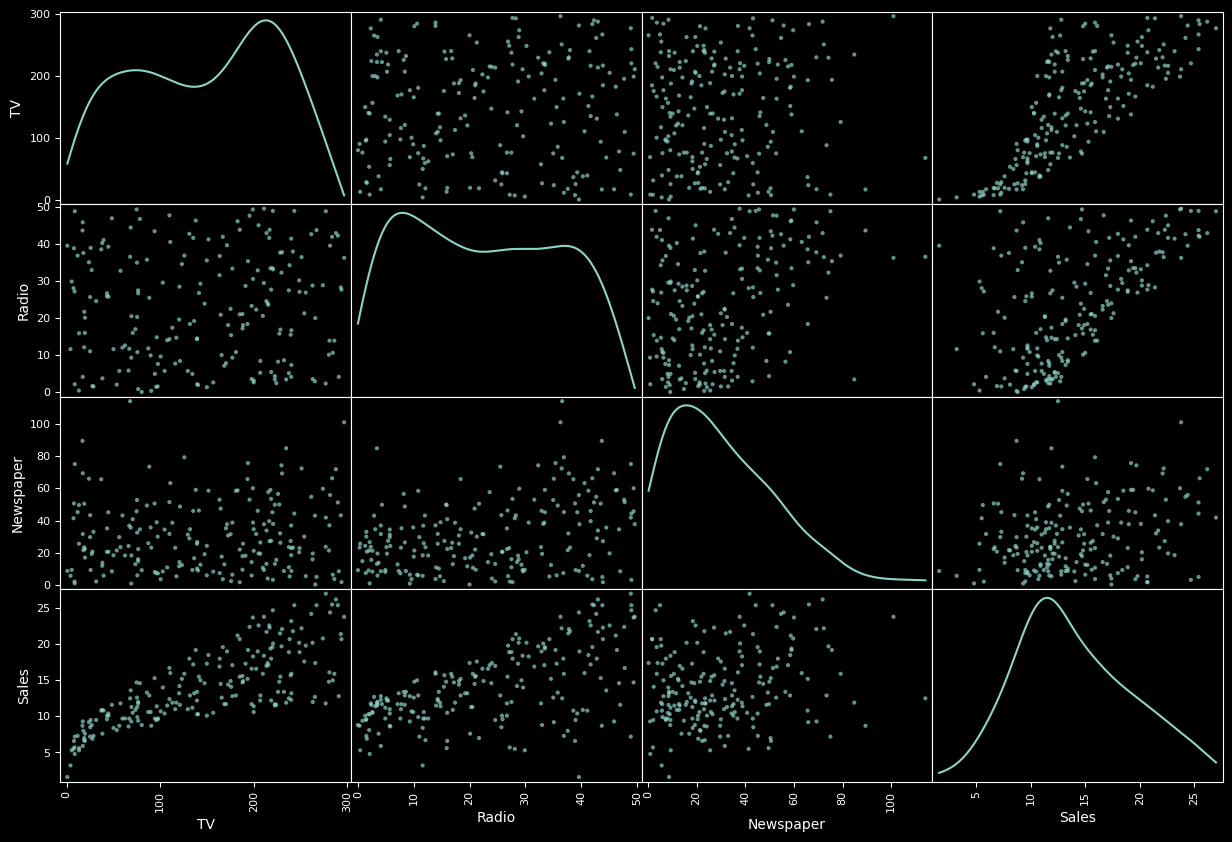

In [3]:
with plt.style.context('dark_background'):
  pd.plotting.scatter_matrix(df, alpha=0.7, figsize=(15, 10), diagonal='kde')
plt.show()

## 2. Realizar los modelos de regresión lineal simple


Variable independiente: TV, Variable dependiente: Radio


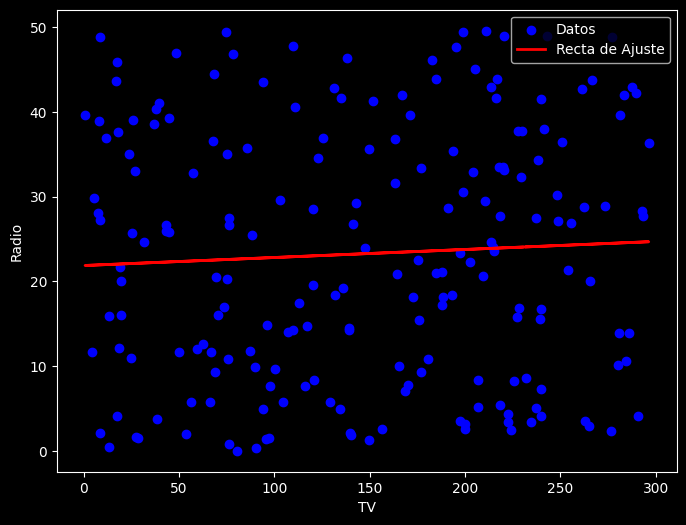

Variable independiente: TV, Variable dependiente: Newspaper


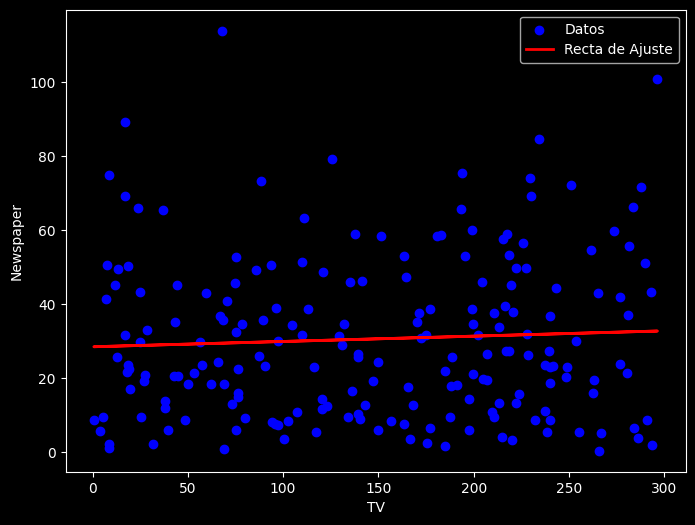

Variable independiente: TV, Variable dependiente: Sales


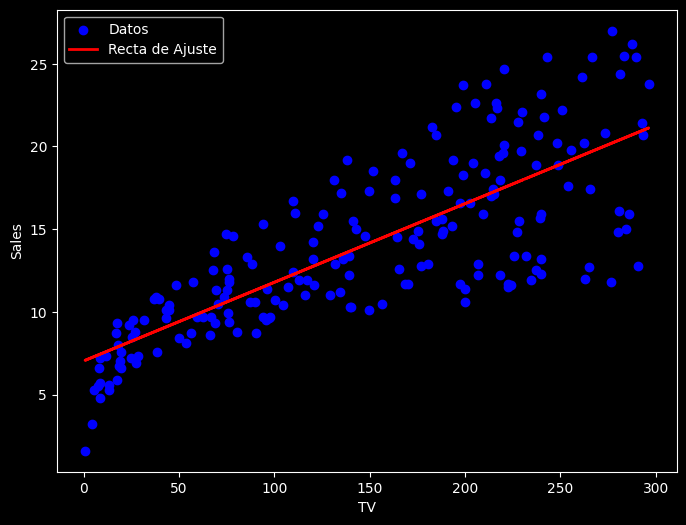

Variable independiente: Radio, Variable dependiente: TV


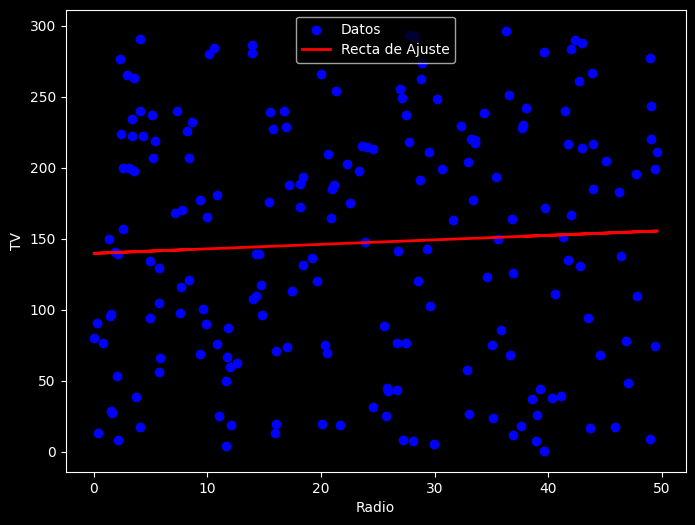

Variable independiente: Radio, Variable dependiente: Newspaper


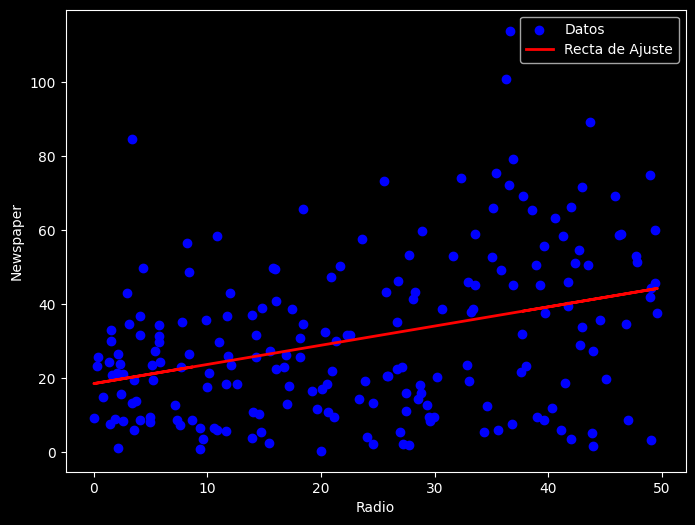

Variable independiente: Radio, Variable dependiente: Sales


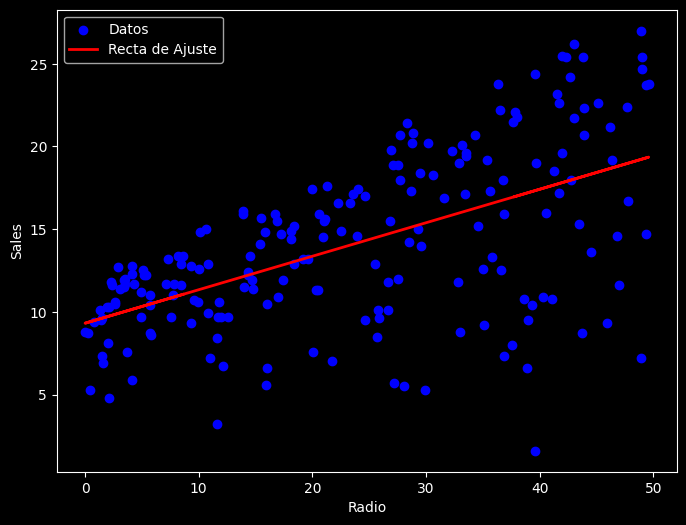

Variable independiente: Newspaper, Variable dependiente: TV


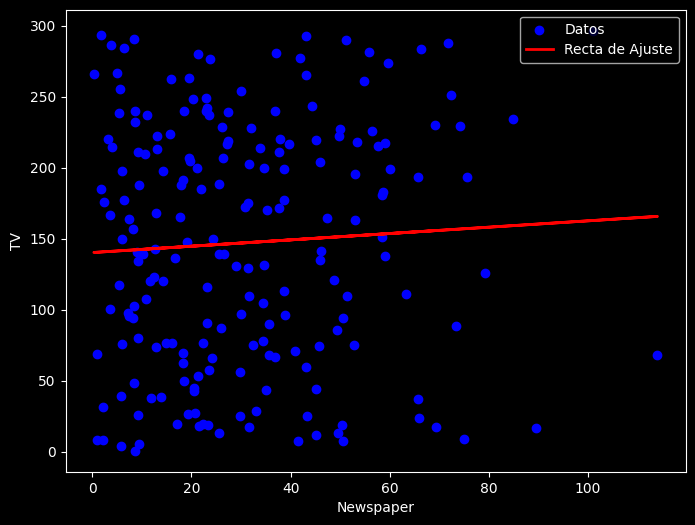

Variable independiente: Newspaper, Variable dependiente: Radio


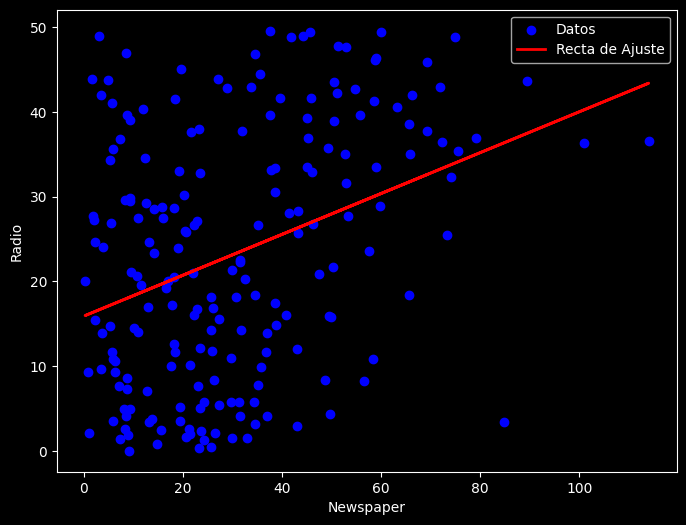

Variable independiente: Newspaper, Variable dependiente: Sales


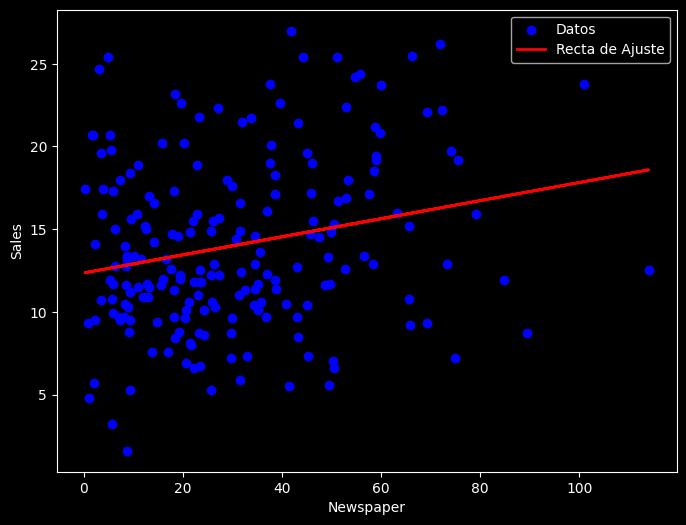

Variable independiente: Sales, Variable dependiente: TV


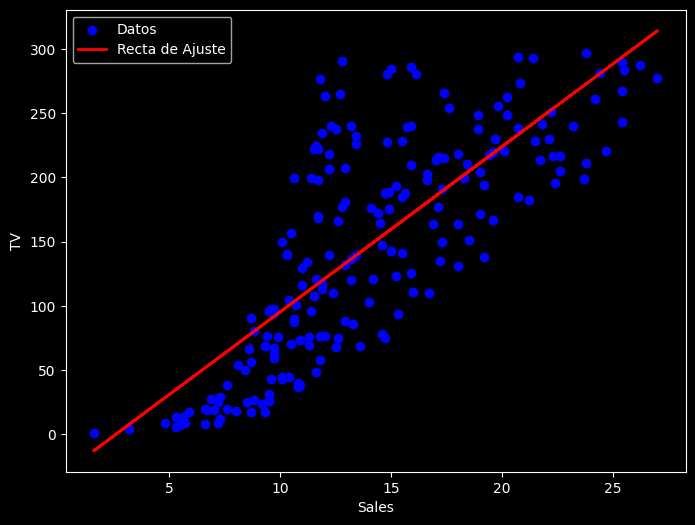

Variable independiente: Sales, Variable dependiente: Radio


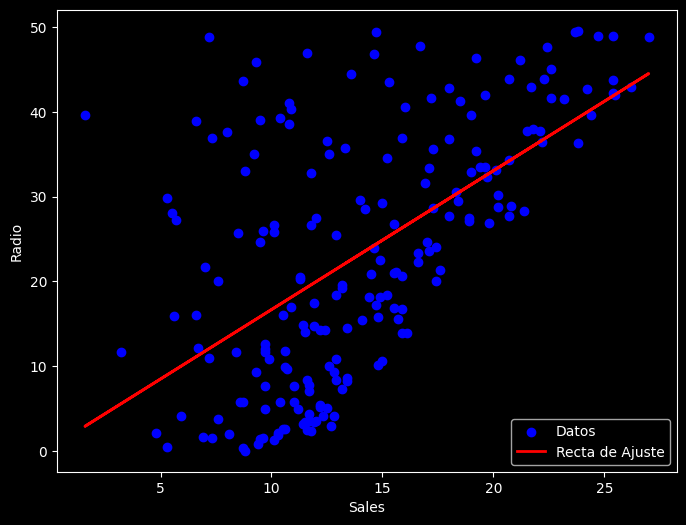

Variable independiente: Sales, Variable dependiente: Newspaper


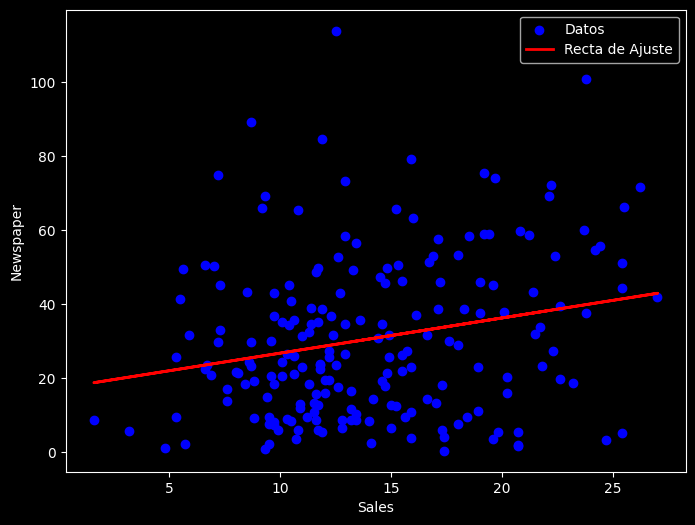

In [4]:
models_dict = {}

def get_model(df, X, y):
  X = sm.add_constant(X) # bo
  model = sm.OLS(y, X).fit()
  return model, X

def plot_model(df, X, y, model):
  print(f"Variable independiente: {col1}, Variable dependiente: {col2}")
  with plt.style.context('dark_background'):
    plt.figure(figsize=(8,6))
    plt.scatter(X.iloc[:, 1], y, color='blue', label='Datos')
    plt.plot(X.iloc[:, 1], model.predict(X), color='red', linewidth=2, label='Recta de Ajuste')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
  plt.show()

results = []
for col1 in df.columns:
  for col2 in df.columns:
    if col1 != col2:
      X = df[col1]
      y = df[col2]
      model, X = get_model(df, X, y)
      models_dict[(col1, col2)] = model
      plot_model(df, X, y, model)
      r_squared = model.rsquared
      adj_r_squared = model.rsquared_adj
      f_test = model.fvalue
      f_test_p_value = model.f_pvalue
      results.append([col1, col2, r_squared, adj_r_squared, f_test, f_test_p_value])

In [5]:
results_df = pd.DataFrame(results, columns=['Independent_Variable', 'Dependent_Variable', 'R_squared', 'Adj_R_squared', 'F_test', 'F_test_p_value'])
sales_results_df = results_df[results_df['Dependent_Variable'] == 'Sales']
styled_sales_df = sales_results_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
display(styled_sales_df)

,Independent_Variable,Dependent_Variable,R_squared,Adj_R_squared,F_test,F_test_p_value
2,TV,Sales,0.611875,0.609915,312.144994,0.000000
5,Radio,Sales,0.332032,0.328659,98.421588,0.000000
8,Newspaper,Sales,0.052120,0.047333,10.887299,0.001148


## 3. Realizar el modelo de regresión lineal múltiple


In [6]:
X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales']

X = sm.add_constant(X)
model_3v = sm.OLS(y, X).fit()
print(model_3v.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.58e-96
Time:                        16:52:30   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

In [7]:
def multiple_regression(X, y):
  X = sm.add_constant(X)
  model = sm.OLS(y, X).fit()

  return model

X1 = df[['TV','Radio']]
X2 = df[['Radio', 'Newspaper']]
X3 = df[['Newspaper', 'TV']]
y = df[['Sales']]

model_tv_radio = multiple_regression(X1, y)
print("Variable independiente: TV y Radio, Variable dependiente: Sales")
print('\n')
print(model_tv_radio.summary())
model_radio_np = multiple_regression(X2, y)
print("Variable independiente: Radio y Newspaper, Variable dependiente: Sales")
print('\n')
print(model_radio_np.summary())
model_radio_tv = multiple_regression(X3, y)
print("Variable independiente: Radio y TV, Variable dependiente: Sales")
print('\n')
print(model_radio_tv.summary())

Variable independiente: TV y Radio, Variable dependiente: Sales


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           4.83e-98
Time:                        16:52:30   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## 4. Realizar diagnóstico del modelo


In [8]:
residuals_3v = model_3v.resid
residuals_radio_tv = model_radio_tv.resid
residuals_tv = models_dict[('TV', 'Sales')].resid

### QQ plot

In [9]:
def plot_QQplot(residuals):
  with plt.style.context('dark_background'):
    sm.qqplot(residuals, line='s')
    plt.title('QQ plot')
  plt.show()

QQ plot of multiple regression with TV, Radio and Newspaper


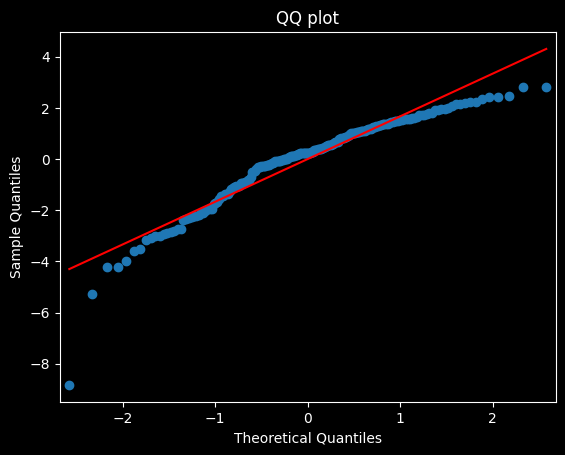

QQ plot of multiple regression with TV and Radio


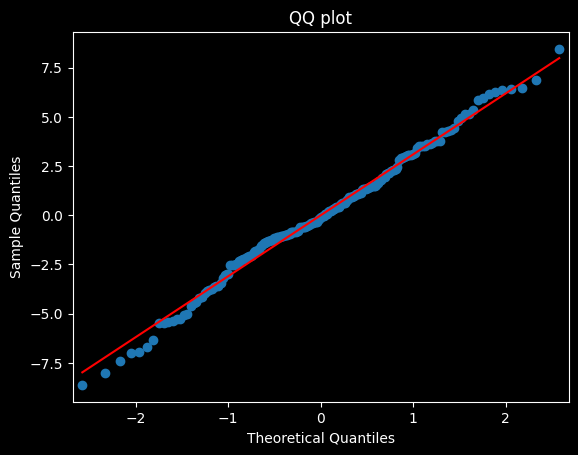

QQ plot of simple regression with TV


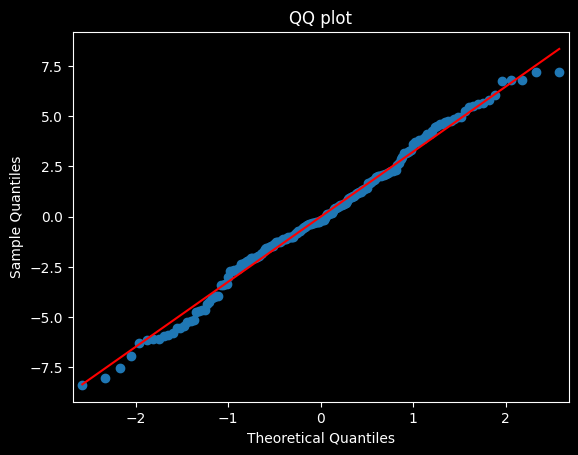

In [10]:
print('QQ plot of multiple regression with TV, Radio and Newspaper')
plot_QQplot(residuals_3v)
print('QQ plot of multiple regression with TV and Radio')
plot_QQplot(residuals_radio_tv)
print('QQ plot of simple regression with TV')
plot_QQplot(residuals_tv)

###Histograma

In [11]:
def plot_histogram(residuals):
  with plt.style.context('dark_background'):
    plt.hist(residuals, bins=15, density=True, alpha=0.6, color='g')
    plt.title('Histogram ')
  plt.show()

Histogram of multiple regression with TV, Radio and Newspaper


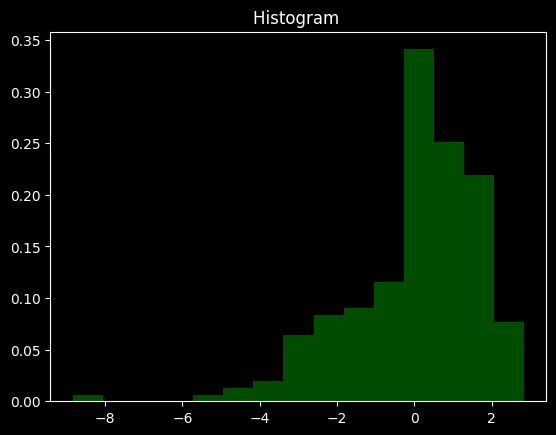

Histogram of multiple regression with TV and Radio


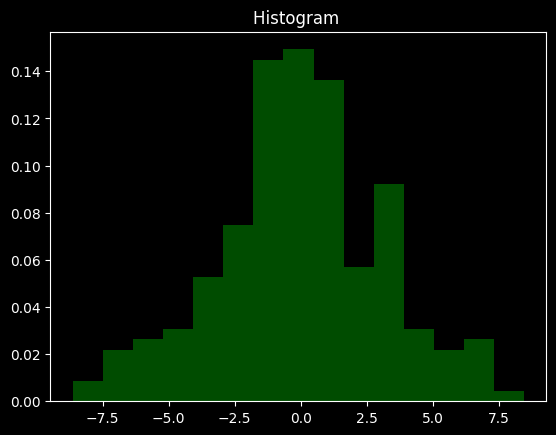

Histogram of simple regression with TV


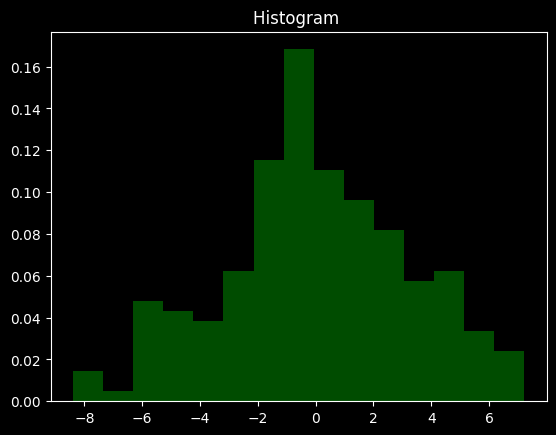

In [12]:
print('Histogram of multiple regression with TV, Radio and Newspaper')
plot_histogram(residuals_3v)
print('Histogram of multiple regression with TV and Radio')
plot_histogram(residuals_radio_tv)
print('Histogram of simple regression with TV')
plot_histogram(residuals_tv)

###Test de normalidad

In [13]:
def normality_test(residuals):
  _, p_value = stats.normaltest(residuals)
  print(f"P-value for normality test: {p_value}")
  if p_value < 0.05:
    print("Los residuos no están distribuidos de manera normal")
  else:
    print("Los residuos están distribuidos de manera normal")

In [14]:
print('Pvalue of TV, Radio and Newspaper')
normality_test(residuals_3v)
print('Pvalue of multiple regression with TV and Radio')
normality_test(residuals_radio_tv)
print('Pvalue of simple regression with TV')
normality_test(residuals_tv)

Pvalue of TV, Radio and Newspaper
P-value for normality test: 7.608085583222855e-14
Los residuos no están distribuidos de manera normal
Pvalue of multiple regression with TV and Radio
P-value for normality test: 0.7197251520351935
Los residuos están distribuidos de manera normal
Pvalue of simple regression with TV
P-value for normality test: 0.7669918486954739
Los residuos están distribuidos de manera normal


## 5. Analizar la influencia de cada variable en las ventas


In [15]:
X = df[["TV", "Radio", "Newspaper"]].to_numpy()
X_2 = sm.add_constant(X[:, :-2])
X_3 = sm.add_constant(X[:, :-1])
Y = df[["Sales"]].to_numpy()

In [16]:
O_tv = models_dict[('TV', 'Sales')].predict(X_2)
O_tv = O_tv.reshape(O_tv.size, 1)
O_tv

array([[17.97077451],
       [ 9.14797405],
       [ 7.85022376],
       [14.23439457],
       [15.62721814],
       [ 7.44616232],
       [ 9.76595037],
       [12.74649773],
       [ 7.44140866],
       [16.53041431],
       [10.17476548],
       [17.23871025],
       [ 8.16396559],
       [11.66741599],
       [16.73482186],
       [16.32125309],
       [10.25557777],
       [20.40940417],
       [10.32212907],
       [14.03474068],
       [17.41459582],
       [18.31779199],
       [ 7.6600772 ],
       [17.88520856],
       [ 9.99412625],
       [19.52997632],
       [13.82557947],
       [18.44614092],
       [18.85970969],
       [10.38868036],
       [20.95607553],
       [12.39948025],
       [11.653155  ],
       [19.65832525],
       [11.58185004],
       [20.85149492],
       [19.72012288],
       [10.58358059],
       [ 9.08142275],
       [17.87094757],
       [16.65876324],
       [15.44657891],
       [20.98935118],
       [16.86792445],
       [ 8.22576322],
       [15

In [17]:
O_radio_tv = model_tv_radio.predict(X_3)
O_radio_tv = O_radio_tv.reshape(O_radio_tv.size, 1)
O_radio_tv

array([[20.55546463],
       [12.34536229],
       [12.33701773],
       [17.61711596],
       [13.22390813],
       [12.51208449],
       [11.71821241],
       [12.10551553],
       [ 3.7093792 ],
       [12.55169696],
       [ 7.0358597 ],
       [17.25652015],
       [10.60866187],
       [ 8.81095051],
       [18.44466773],
       [20.82891539],
       [12.90386507],
       [23.24107626],
       [ 9.94121476],
       [14.15384619],
       [18.12139161],
       [14.74206357],
       [ 6.51417168],
       [16.54402663],
       [ 8.14035215],
       [15.6080206 ],
       [14.96769383],
       [17.0463346 ],
       [19.39954145],
       [ 9.15929748],
       [21.64292187],
       [11.35791808],
       [ 7.65045928],
       [18.83346334],
       [ 7.56302763],
       [16.99280099],
       [23.36720719],
       [15.6258994 ],
       [ 9.91257829],
       [20.4405801 ],
       [16.37872122],
       [17.29870935],
       [21.5621537 ],
       [13.96692266],
       [ 8.9009974 ],
       [15

In [18]:
import seaborn as sns

### TV

In [19]:
np.corrcoef(X[:,0], Y[:, 0])

array([[1.        , 0.78222442],
       [0.78222442, 1.        ]])

In [20]:
tv_df = pd.DataFrame(data={"TV": X[:, 0], "Sales" : Y[:, 0]})

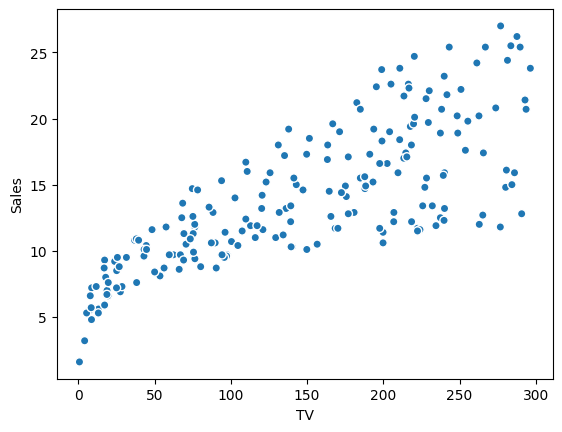

In [21]:
sns.scatterplot(tv_df, x="TV", y="Sales", marker="o", linestyle="")
plt.show()

In [22]:
np.corrcoef(X[:,0], O_tv[:,0])

array([[1., 1.],
       [1., 1.]])

In [23]:
m_tv_df = pd.DataFrame(data={"TV": X[:, 0], "Sales" : O_tv[:, 0]})

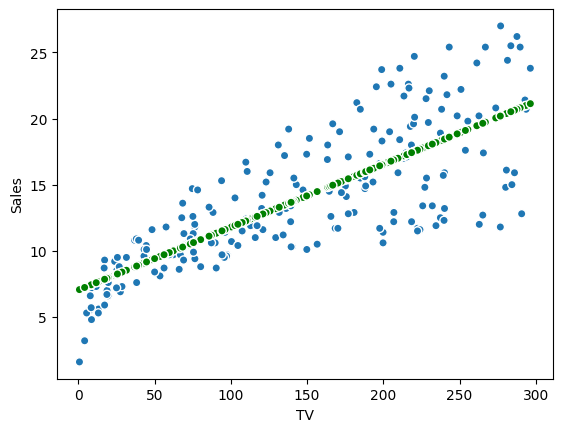

In [24]:
sns.scatterplot(tv_df, x="TV", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_tv_df, x="TV", y="Sales", marker="o", linestyle="", color="green")
plt.show()

In [25]:
np.corrcoef(X[:,0], O_radio_tv[:,0])

array([[1.       , 0.8258252],
       [0.8258252, 1.       ]])

In [26]:
m_rtv_df = pd.DataFrame(data={"TV": X[:, 0], "Sales" : O_radio_tv[:, 0]})

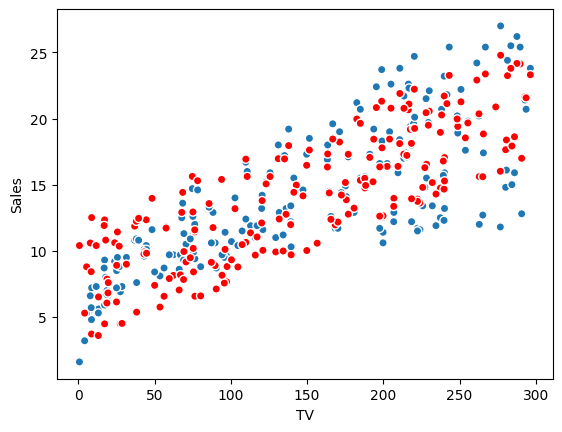

In [27]:
sns.scatterplot(tv_df, x="TV", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_rtv_df, x="TV", y="Sales", marker="o", linestyle="", color="red")
plt.show()

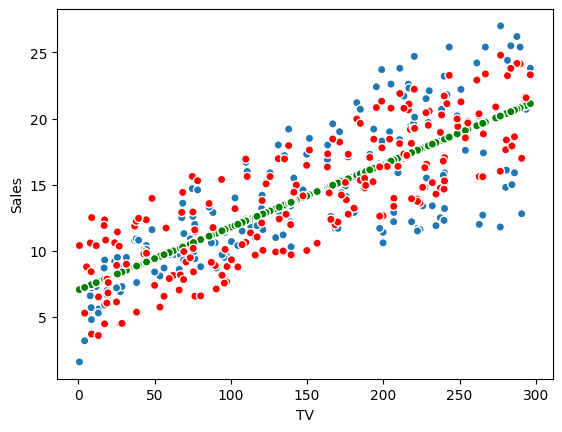

In [28]:
sns.scatterplot(tv_df, x="TV", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_tv_df, x="TV", y="Sales", marker="o", linestyle="", color="green")
sns.scatterplot(m_rtv_df, x="TV", y="Sales", marker="o", linestyle="", color="red")
plt.show()

### Radio

In [29]:
np.corrcoef(X[:,1], Y[:, 0])

array([[1.        , 0.57622257],
       [0.57622257, 1.        ]])

In [30]:
tv_df = pd.DataFrame(data={"Radio": X[:, 1], "Sales" : Y[:, 0]})

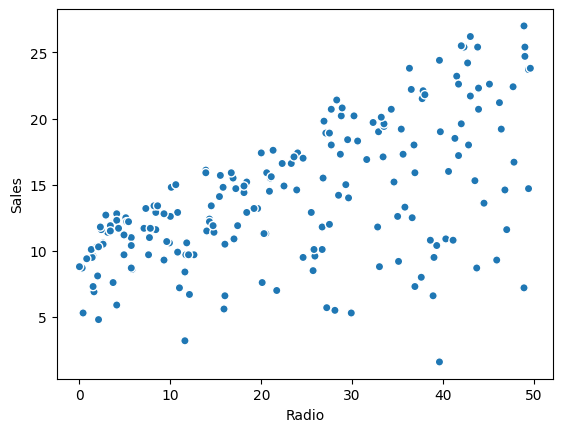

In [31]:
sns.scatterplot(tv_df, x="Radio", y="Sales", marker="o", linestyle="")
plt.show()

In [32]:
np.corrcoef(X[:,1], O_tv[:,0])

array([[1.        , 0.05480866],
       [0.05480866, 1.        ]])

In [33]:
m_tv_df = pd.DataFrame(data={"Radio": X[:, 1], "Sales" : O_tv[:, 0]})

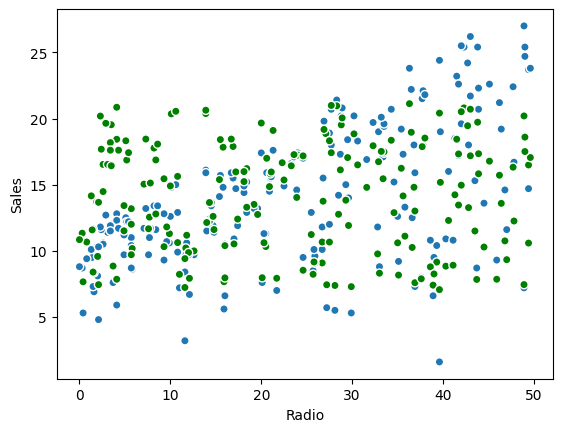

In [34]:
sns.scatterplot(tv_df, x="Radio", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_tv_df, x="Radio", y="Sales", marker="o", linestyle="", color="green")
plt.show()

In [35]:
np.corrcoef(X[:,1], O_radio_tv[:,0])

array([[1.        , 0.60834091],
       [0.60834091, 1.        ]])

In [36]:
m_rtv_df = pd.DataFrame(data={"Radio": X[:, 1], "Sales" : O_radio_tv[:, 0]})

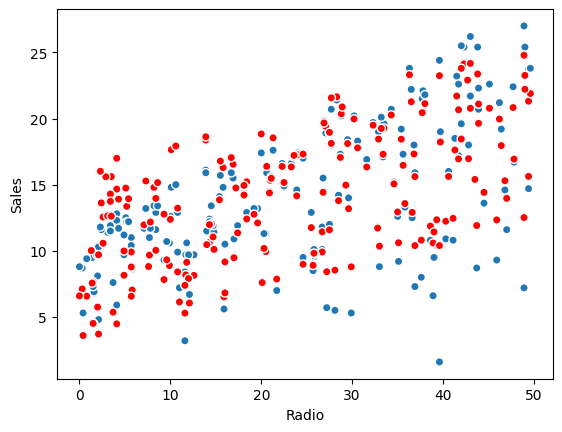

In [37]:
sns.scatterplot(tv_df, x="Radio", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_rtv_df, x="Radio", y="Sales", marker="o", linestyle="", color="red")
plt.show()

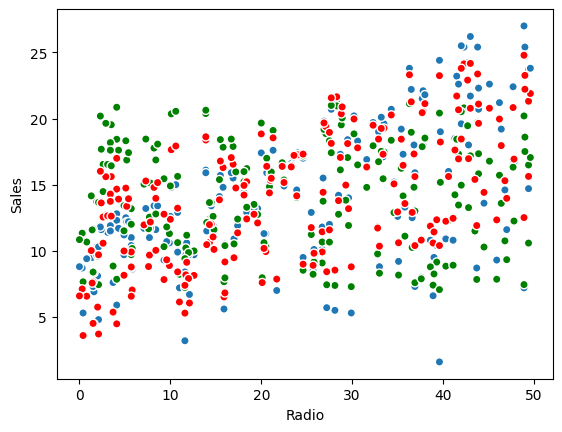

In [38]:
sns.scatterplot(tv_df, x="Radio", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_tv_df, x="Radio", y="Sales", marker="o", linestyle="", color="green")
sns.scatterplot(m_rtv_df, x="Radio", y="Sales", marker="o", linestyle="", color="red")
plt.show()

### Newspaper

In [39]:
np.corrcoef(X[:,2], Y[:, 0])

array([[1.        , 0.22829903],
       [0.22829903, 1.        ]])

In [40]:
tv_df = pd.DataFrame(data={"Newspaper": X[:, 2], "Sales" : Y[:, 0]})

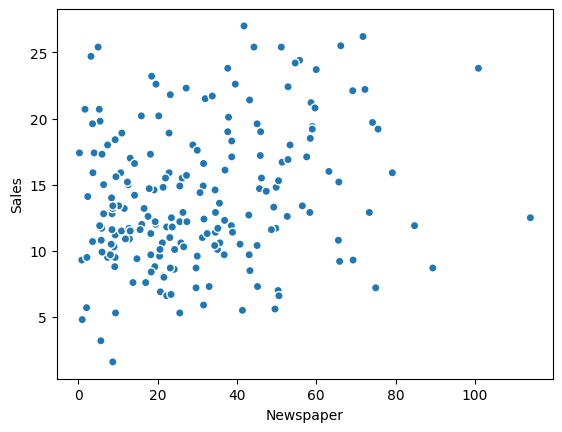

In [41]:
sns.scatterplot(tv_df, x="Newspaper", y="Sales", marker="o", linestyle="")
plt.show()

In [42]:
np.corrcoef(X[:,2], O_tv[:,0])

array([[1.        , 0.05664787],
       [0.05664787, 1.        ]])

In [43]:
m_tv_df = pd.DataFrame(data={"Newspaper": X[:, 2], "Sales" : O_tv[:, 0]})

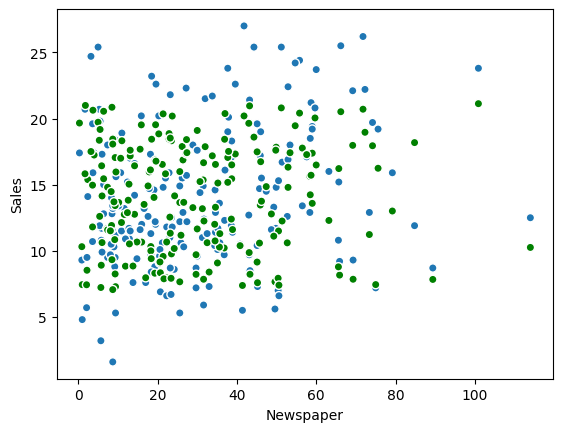

In [44]:
sns.scatterplot(tv_df, x="Newspaper", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_tv_df, x="Newspaper", y="Sales", marker="o", linestyle="", color="green")
plt.show()

In [45]:
np.corrcoef(X[:,2], O_radio_tv[:,0])

array([[1.        , 0.24501672],
       [0.24501672, 1.        ]])

In [46]:
m_rtv_df = pd.DataFrame(data={"Newspaper": X[:, 2], "Sales" : O_radio_tv[:, 0]})

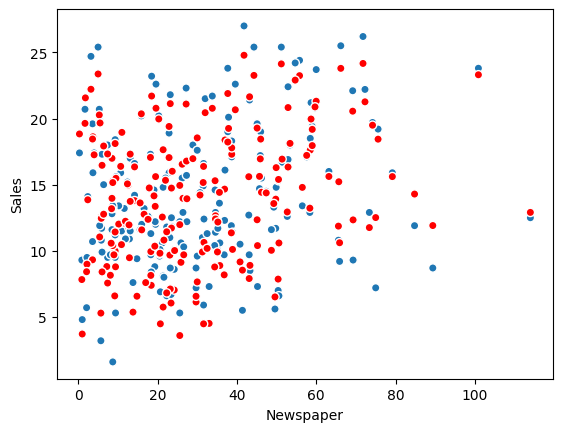

In [47]:
sns.scatterplot(tv_df, x="Newspaper", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_rtv_df, x="Newspaper", y="Sales", marker="o", linestyle="", color="red")
plt.show()

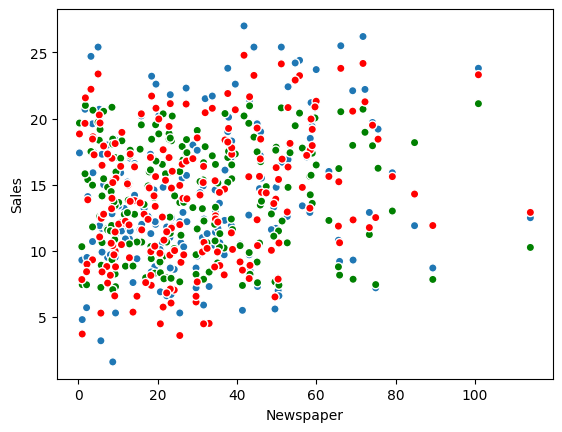

In [48]:
sns.scatterplot(tv_df, x="Newspaper", y="Sales", marker="o", linestyle="")
sns.scatterplot(m_tv_df, x="Newspaper", y="Sales", marker="o", linestyle="", color="green")
sns.scatterplot(m_rtv_df, x="Newspaper", y="Sales", marker="o", linestyle="", color="red")
plt.show()

## 6. Dividir el conjunto total en un conjunto de entrenamiento y otro de prueba y calcular las matrices de confusión, accuracy, precision y recall

In [49]:
X_train_3v, X_test_3v, y_train_3v, y_test_3v = train_test_split(X, y, test_size=0.2, random_state=42)
model_tt_3v = sm.OLS(y_train_3v, X_train_3v).fit()
y_pred_3v = model_tt_3v.predict(X_test_3v)

Las matrices de confusión, la precisión, la recuperación y la exactitud se utilizan típicamente en problemas de clasificación, no en problemas de regresión. Para un problema de regresión, normalmente se evalúa el rendimiento utilizando métricas como el error cuadrático medio (MSE), el error absoluto medio (MAE) o el coeficiente de determinación (R-cuadrado).

In [50]:
mse_3v = mean_squared_error(y_test_3v, y_pred_3v)
r2_3v = r2_score(y_test_3v, y_pred_3v)
print(f"Mean Squared Error: {mse_3v}")
print(f"R-squared: {r2_3v}")

Mean Squared Error: 4.601855988276691
R-squared: 0.8542036745015231


Calculamos solo teniendo en cuenta radio y TV

In [51]:
X_train_radio_tv, X_test_radio_tv, y_train_radio_tv, y_test_radio_tv = train_test_split(X1, y, test_size=0.2, random_state=42)
model_tt_radio_tv = sm.OLS(y_train_radio_tv, X_train_radio_tv).fit()
y_pred_radio_tv = model_tt_radio_tv.predict(X_test_radio_tv)

In [52]:
mse_radio_tv = mean_squared_error(y_test_radio_tv, y_pred_radio_tv)
r2_radio_tv = r2_score(y_test_radio_tv, y_pred_radio_tv)
print(f"Mean Squared Error: {mse_radio_tv}")
print(f"R-squared: {r2_radio_tv}")

Mean Squared Error: 4.232974586321039
R-squared: 0.8658906010561285


In [53]:
X = df['TV']
X_train_tv, X_test_tv, y_train_tv, y_test_tv = train_test_split(X1, y, test_size=0.2, random_state=42)
model_tt_tv = sm.OLS(y_train_tv, X_train_tv).fit()
y_pred_tv = model_tt_tv.predict(X_test_tv)

In [54]:
mse_tv = mean_squared_error(y_test_tv, y_pred_tv)
r2_tv = r2_score(y_test_tv, y_pred_tv)
print(f"Mean Squared Error: {mse_tv}")
print(f"R-squared: {r2_tv}")

Mean Squared Error: 4.232974586321039
R-squared: 0.8658906010561285
